# The McCall Job Search Model

## Sketch of the model

* Job seekers are risk neutral, discount the future at rate $\beta$, and are infinitely lived.
  * Utility: $U = \sum_{t=0}^{\infty} \beta^t c_t$
  * Decision: accept or reject offer
* Firms post wage offers drawn from a known distribution $F(w)$.
  * Make no decisions, just post wage offers
  * One hire a worker at wage $w$, they are employed forever at that wage
* This is a model of *undirected search*
* No recall -- workers cannot return to previous job offers
* Workers receive job offers sequentially, one per model period
* Wage offers are iid draws from $F(w)$
* This is a partial equilibrium model

## Bellman equation

The value of receiving a wage offer of $w$ is:
$$
v(w) = \max\left\{ \frac{w}{1 - \beta}, b + \beta \int_W v(w') dF(w') \right\}
$$

We'll solve this model for the implicit function $v(w)$ and the decision rule, when to accept of reject an offer.  This will be a cutoff rule, defined by a "reservation wage", $R$.  For $w \geq R$ the offer is accepted, for $w < R$ the offer is rejected.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

In [2]:
# Create a grid of wages over which to evaluate v(w)
w_min, w_max = 10, 100  # min and max values
n = 100000 # number of grid points for wages
wages = np.linspace(w_min, w_max, n)  # use linearly spaced grid over the given support

# Define a vector of probabilities
# Each value is the probability of drawing the corresponding wage in
# the wages vector
# Assumption is that wages are drawn from a log normal
# distribution with mean mu and standard deviation sigma
mu = np.log(40)
sigma = 0.5
p = stats.lognorm.pdf(wages, s=sigma, scale=np.exp(mu))
p = p / p.sum() # normalize bc wage vector is bounded


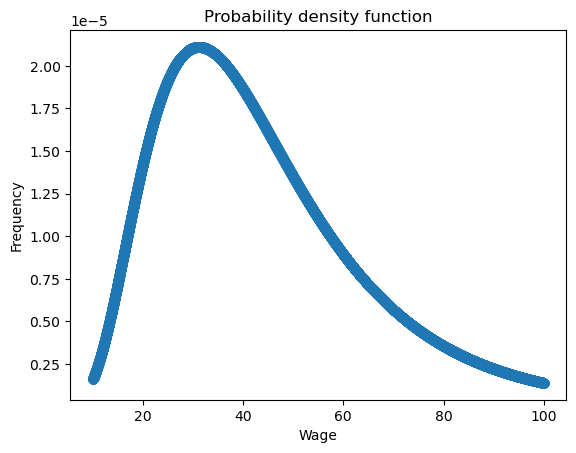

In [3]:
# plot probability density function
plt.scatter(wages, p)
plt.title('Probability density function')
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.show()

In [4]:
# Set other model parameters
beta = 0.99  # discount factor
# Unemployment benefits, b
# assume replacement rate theta = 0.3
# benefits, b = theta * mean_wage
expected_wage = np.sum(wages * p)
theta = 0.3
b = theta * expected_wage  # 30% replacement rate, on average
print(f'Expected wage: {expected_wage:.2f}')
print(f'UI benefits: {b:.2f}')

Expected wage: 42.71
UI benefits: 12.81


In [5]:
# Solve the model with value function iteration
V = np.zeros(wages.size)  # value function guess, could have better one
V_matrix = V.reshape(n, 1)  # will use this to keep track of V at each iteration
phi = np.zeros(wages.size) # policy function
v_tol = 1e-6
v_dist = 10
max_iter = 1000
iter = 0
time_start = time.time()
while (v_dist > v_tol) & (iter < max_iter):
    TV = np.empty_like(V)
    EV = np.sum(V * p)
    v_search = b + beta * EV
    v_accept = np.empty_like(wages)
    for i, w in enumerate(wages):
        v_accept[i] = w / (1 - beta)
    TV = np.maximum(v_accept, v_search)
    phi = v_accept > v_search
    v_dist = np.abs(V-TV).max()
    print("Iteration ", iter, ", and distance is ", v_dist)
    V = TV
    V_matrix = np.hstack((V_matrix, V.reshape(n, 1)))
    iter += 1
time_end = time.time()
print(f'Value function iteration took {time_end - time_start:.2f} seconds')






Iteration  0 , and distance is  9999.99999999999
Iteration  1 , and distance is  3240.962109747601
Iteration  2 , and distance is  737.8376027186014
Iteration  3 , and distance is  460.5526736527372
Iteration  4 , and distance is  330.24678173919983
Iteration  5 , and distance is  253.41063744391886
Iteration  6 , and distance is  202.5799660204384
Iteration  7 , and distance is  166.4773743035521
Iteration  8 , and distance is  139.55908595386427
Iteration  9 , and distance is  118.76541748771524
Iteration  10 , and distance is  102.26394250665362
Iteration  11 , and distance is  88.88807219342652
Iteration  12 , and distance is  77.85889727232552
Iteration  13 , and distance is  68.63608670185477
Iteration  14 , and distance is  60.83284531806203
Iteration  15 , and distance is  54.164901762649606
Iteration  16 , and distance is  48.41860360690953
Iteration  17 , and distance is  43.43024706437063
Iteration  18 , and distance is  39.072275327568605
Iteration  19 , and distance is  35

Text(0, 0.5, '$V(w)$')

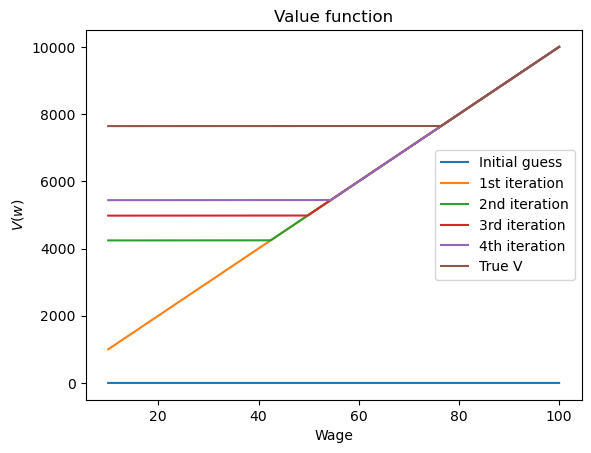

In [6]:
# plot value function at several iterations
plt.plot(wages, V_matrix[:, 0], label="Initial guess")
plt.plot(wages, V_matrix[:, 1], label="1st iteration")
plt.plot(wages, V_matrix[:, 2], label="2nd iteration")
plt.plot(wages, V_matrix[:, 3], label="3rd iteration")
plt.plot(wages, V_matrix[:, 4], label="4th iteration")
plt.plot(wages, V, label="True V")
plt.legend()
plt.title('Value function')
plt.xlabel('Wage')
plt.ylabel('$V(w)$')

Text(0, 0.5, 'Accept (1) or Reject (0)')

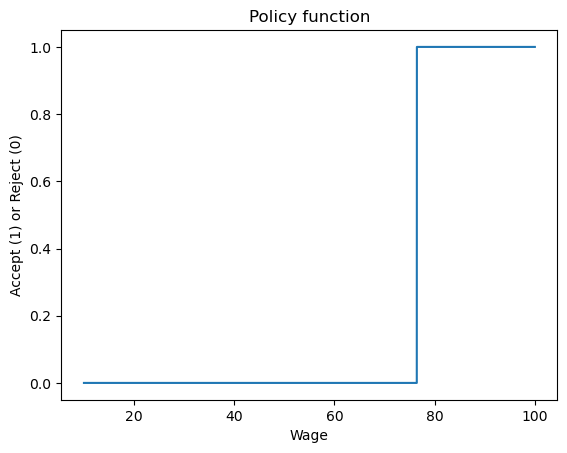

In [7]:
# plot policy function
plt.plot(wages, phi)
plt.title('Policy function')
plt.xlabel('Wage')
plt.ylabel('Accept (1) or Reject (0)')

In [8]:
# Return reservation wage
R = wages[np.argmax(phi)]
print(f"Reservation wage is R = {R:.2f}")
# {b:.2f}')

Reservation wage is R = 76.43


In [9]:
# create a function to do the above
def McCallModel(wages, p, beta=0.99, theta=0.3, max_iter=1000, v_tol=1e-6):
    expected_wage = np.sum(wages * p)
    b = theta * expected_wage
    V = wages / (1 - beta)  # value function guess
    phi = np.zeros(wages.size)  # policy function
    v_dist = 10
    iter = 0
    while (v_dist > v_tol) & (iter < max_iter):
        EV = np.sum(V * p)
        v_search = b + beta * EV
        v_accept = np.empty_like(wages)
        for i, w in enumerate(wages):
            v_accept[i] = wages[i] / (1 - beta)
        TV = np.maximum(v_accept, v_search)
        phi = v_accept > v_search
        v_dist = np.abs(V - TV).max()
        V = TV
        iter += 1
    R = wages[np.argmax(phi)]
    return R

In [10]:
R = McCallModel(wages, p)
print(f"Reservation wage is R = {R:.2f}")

Reservation wage is R = 76.43


## Speedup #1, Numba

This is a pretty simple model and can be completely vectorized for fast operations in Python (Note that what's above could be further vectorized as the `v_accept` values can be computed outside the VFI loop).

But to illustrate how [Numba](https://numba.pydata.org) can make your Python code run much faster, we'll leave in these inefficiencies.

### What is Numba?

Before we talk about Numba, it's worth reminding our selves that Python is an *interpreted* language.  This means that the Python code you write is not directly executed by the computer.  Instead, it is first translated into an intermediate form, called *byte code*, which is then executed by the Python interpreter.  This is why Python is slow compared to compiled languages like C or Fortran.

What Numba supports is "just in time" compilation of your Python code.  That is, when we use Numba, we can have the our Python code translated into machine code just before it is executed.  This can make the code run much faster.  And Numba can do this with many standard Python functions and operations, often with just the addition of few simple []"decorators"](https://realpython.com/primer-on-python-decorators/) to our code.

Before we modify our code, we'll need to import Numba:


In [11]:
# Import numba's just in time (JIT) compiler
from numba import jit

## Apply Numba's `@jit` Decorator

In our functions above to solve for $v(w)$ we had two loops: (1) a `while` loop over our Bellman operator and (2) a `for` loop inside this Bellman operator:

```py
v_accept = np.empty_like(wages)
    for i, w in enumerate(wages):
        v_accept[i] = w / (1 - beta)
    return v_accept
```

Again, note that this is not very efficient to use this loop.  We we could have vectorized this operation.  e..g, 
```py
v_accept = wages / (1 - beta)
```

and we could move the calculation of `v_accept` outside the `while` loop since it doesn't depend on $v(w)$.

**But let's ignore that** for now so we can show how to implement Numba and its potential speed ups.

### A note on "jitted" functions

An important constraint to be aware of with Numba is that is Numba works best with basic Python (not custom classes and not with complex modules such as SciPy).  And with some things it doesn't just slow down, but doesn't work at all.  For example, we can't "JIT" the whole `McCallModel()` function since Numba isn't going to like the "if" statements (among other things).

Also, note that there is some overhead the first time a "JIT-ed" function is compiled.  So efficiency gains from just in time compilation increase for functions that are called repeatedly.

In [24]:
# Copy same code as above, but add @jit decorator to a new function that replaces
# the loop inside the Bellman operator loop that determined the value
# of accepting wage w
@jit
def accept_values(wages, p, beta):
    v_accept = np.empty_like(wages)
    for i, w in enumerate(wages):
        v_accept[i] = w / (1 - beta)
    return v_accept


# Solve the model with value function iteration
def McCallModel_jit(wages, p, beta=0.99, theta=0.3, max_iter=1000, v_tol=1e-6):
    expected_wage = np.sum(wages * p)
    b = theta * expected_wage
    V = wages / (1 - beta)  # value function guess
    phi = np.zeros(wages.size)  # policy function
    v_dist = 10
    iter = 0
    while (v_dist > v_tol) & (iter < max_iter):
        EV = np.sum(V * p)
        v_search = b + beta * EV
        v_accept = accept_values(wages, p, beta)
        TV = np.maximum(v_accept, v_search)
        phi = v_accept > v_search
        v_dist = np.abs(V - TV).max()
        V = TV
        iter += 1
    R = wages[np.argmax(phi)]
    return R

In [25]:
# Test the speed of these the first implementation and that using Numba
%timeit R1 = McCallModel(wages, p)
%timeit R2 = McCallModel_jit(wages, p)
R1 = McCallModel(wages, p)
R2 = McCallModel_jit(wages, p)
print("Difference in reservation wages = ", R2 - R1)


4.07 s ± 65.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
52.9 ms ± 461 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Difference in reservation wages =  0.0


So in this case, Numba gives us a speed up of almost an order of magnitude!  Not bad for a simple change in our code!

## An Alternative Solution Method

We write the job search problem slightly differently and in a way that leads to a more computationally efficient solution than the Bellman operator above.  To see this let $h$ denote the continuation value:
$$
h = b + \beta \int_W v(w) dF(w)
$$

The Bellman equation can be written as:
$$
v(w) = \max\left\{ \frac{w}{1 - \beta}, h \right\}
$$
Which means we can rewrite $h$ as:
$$
h = b + \beta \int_W \max\left\{ \frac{w}{1 - \beta}, h \right\} dF(w)
$$

This is a nonlinear equation in $h$, which we can solve using a contraction mapping theorem. We can start with some initial guess for $h$ and apply the Bellman operator, $T(h)$ to it:

$$
T(h) = b + \beta \int_W \max\left\{ \frac{w}{1 - \beta}, h \right\} dF(w)
$$

By applying the operator repeatedly we will converge to the fixed point.  Note that in the Bellman operator on the value function, we had vector of $v(w)$ (for each possible wage), here we just have a scalar $h$.

In [14]:
# Alternate solution -- solve for the reservation wage directly
def McCallModel_v2(wages, p, beta=0.99, theta=0.3, max_iter=1000, h_tol=1e-6):
    h = 0  # reservation wage guess
    h_dist = 10
    iter = 0
    avg_wage = np.sum(wages * p)
    b = theta * avg_wage
    continue_wage = wages / (1 - beta)
    while (h_dist > h_tol) & (iter < max_iter):
        h_new = b + beta * np.sum(np.maximum(continue_wage, h) * p)
        h_dist = np.abs(h_new - h).max()
        h = h_new
        iter += 1
    w_bar = (1 - beta) * h
    return w_bar

In [15]:
R =  McCallModel_v2(wages, p)
print(f"Reservation wage is R = {R:.2f}")

Reservation wage is R = 76.43


## Comparative Statics

We can use our model to look at some interesting comparative statics.

For example:
* How does the reservation wage change with the unemployment benefit?
* How does time unemployed change with the unemployment benefit?

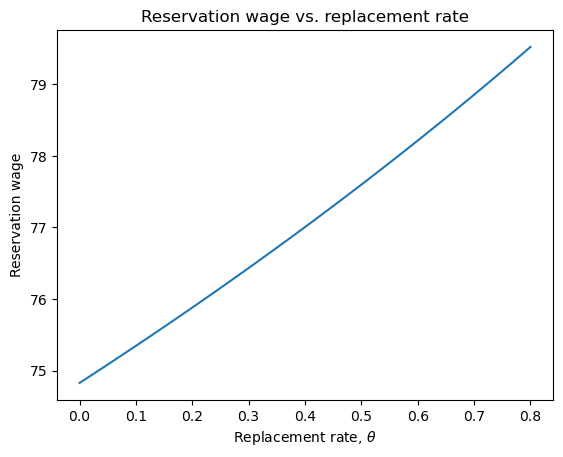

In [16]:
# How does reservation wage change with replacement rate?
n_theta = 100  # number of values for theta
theta_vals = np.linspace(0, 0.8, n_theta)
R_wages = np.empty_like(theta_vals)
for i, theta in enumerate(theta_vals):
    R_wages[i] = McCallModel_v2(wages, p, theta=theta)
plt.plot(theta_vals, R_wages)
plt.xlabel(r'Replacement rate, $\theta$')
plt.ylabel('Reservation wage')
plt.title('Reservation wage vs. replacement rate')
plt.show()

In [17]:
# To find the time searching/time unemployed, we need to
# simulation some draws from the wage distribution
T = 1_000 # number of draws in each sequence
N = 10_000 # number of sequences
wage_offers = np.random.choice(wages, T * N, p=p)
wage_offers = wage_offers.reshape(T, N)

In [18]:
# @jit
def wait_times(n_b, n_seq, n_draws, b_vals, r_wages, wage_offers):
    wait_times = np.empty((n_b, n_seq))
    # make draws of series of wage offers to see how long until accept
    for i, b in enumerate(b_vals):
        wait_times[i, :] = 0
        for j in range(n_draws):
            accept = False
            offer = 0
            while (not accept) & (wait_times[i, j] < n_seq):
                # find the first wage offer greater than reservation wage
                accept = wage_offers[i, j, offer] > r_wages[i]
                if accept:
                    wait_times[i, j] = wait_times[i, j] + 1
                else:
                    wait_times[i, j] += 1
                    offer += 1
            # compute average over the n_draws
        wait_times_avg = wait_times.mean(axis=1)
    return wait_times_avg

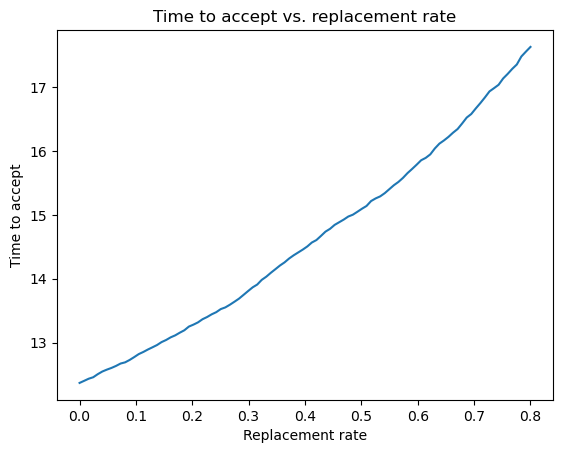

In [19]:
# How does time to accept change with replacement rate?
stop_times = np.empty_like(theta_vals)
for i, theta in enumerate(theta_vals):
    R = McCallModel_v2(wages, p, theta=theta)
    wait_time = np.argmax(wage_offers > R, axis=0)
    stop_times[i] = wait_time.mean()

# plot
plt.plot(theta_vals, stop_times)
plt.xlabel('Replacement rate')
plt.ylabel('Time to accept')
plt.title('Time to accept vs. replacement rate')
plt.show()

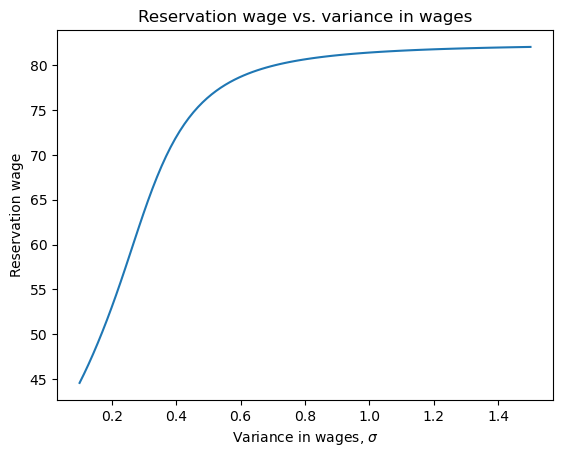

In [20]:
# How does reservation wage change with wage distribution, variance?
n_sigma = 100  # number of values for theta
sigma_vals = np.linspace(0.1, 1.5, n_sigma)
R_wages = np.empty_like(sigma_vals)
for i, sigma in enumerate(sigma_vals):
    p_sigma = stats.lognorm.pdf(wages, s=sigma, scale=np.exp(mu))
    p_sigma = p_sigma / p_sigma.sum() # normalize bc wage vector is bounded
    R_wages[i] = McCallModel_v2(wages, p_sigma)
plt.plot(sigma_vals, R_wages)
plt.xlabel(r'Variance in wages, $\sigma$')
plt.ylabel('Reservation wage')
plt.title('Reservation wage vs. variance in wages')
plt.show()

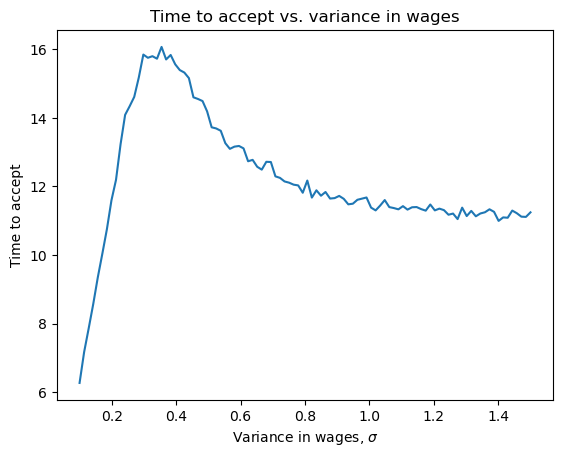

In [21]:
# How does time to accept change with wage distribution, variance?
stop_times = np.empty_like(sigma_vals)
T = 1_000 # number of draws in each sequence
N = 10_000 # number of sequences
for i, sigma in enumerate(sigma_vals):
    p_sigma = stats.lognorm.pdf(wages, s=sigma, scale=np.exp(mu))
    p_sigma = p_sigma / p_sigma.sum() # normalize bc wage vector is bounded
    wage_offers = np.random.choice(wages, T * N, p=p_sigma)
    wage_offers = wage_offers.reshape(T, N)
    R = McCallModel_v2(wages, p_sigma)
    wait_time = np.argmax(wage_offers > R, axis=0)
    stop_times[i] = wait_time.mean()

# plot
plt.plot(sigma_vals, stop_times)
plt.xlabel(r'Variance in wages, $\sigma$')
plt.ylabel('Time to accept')
plt.title('Time to accept vs. variance in wages')
plt.show()

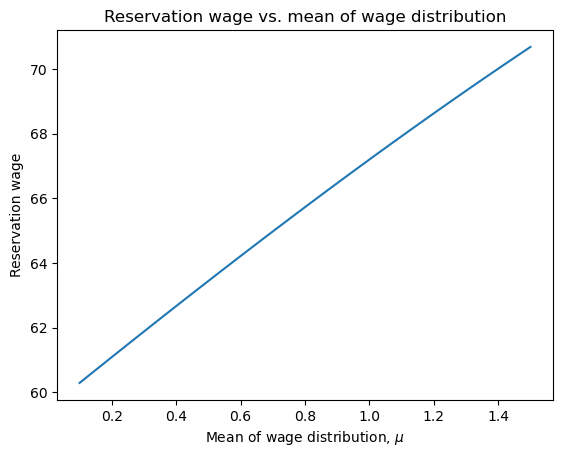

In [22]:
# How does reservation wage change with wage distribution, mean?
# How does reservation wage change with wage distribution, variance?
n_mu = 100  # number of values for theta
mu_vals = np.linspace(0.1, 1.5, n_mu)
R_wages = np.empty_like(mu_vals)
for i, mu in enumerate(mu_vals):
    p_mu = stats.lognorm.pdf(wages, s=sigma, scale=np.exp(mu))
    p_mu = p_mu / p_mu.sum() # normalize bc wage vector is bounded
    R_wages[i] = McCallModel_v2(wages, p_mu)
plt.plot(mu_vals, R_wages)
plt.xlabel(r'Mean of wage distribution, $\mu$')
plt.ylabel('Reservation wage')
plt.title('Reservation wage vs. mean of wage distribution')
plt.show()

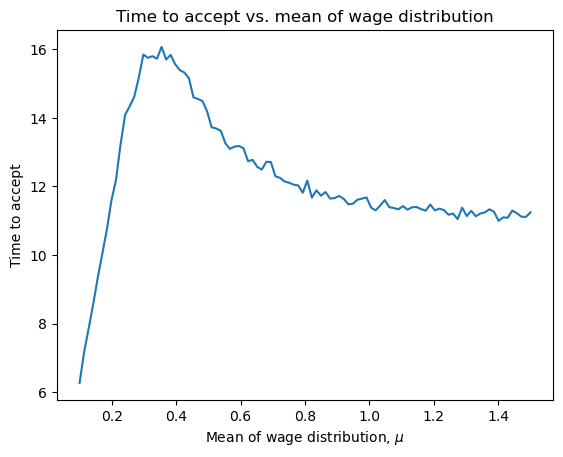

In [23]:
# How does time to accept change with wage distribution, mean?
stop_times = np.empty_like(sigma_vals)
T = 1_000 # number of draws in each sequence
N = 10_000 # number of sequences
R_wages = np.empty_like(mu_vals)
for i, mu in enumerate(mu_vals):
    p_mu = stats.lognorm.pdf(wages, s=sigma, scale=np.exp(mu))
    p_mu = p_mu / p_mu.sum() # normalize bc wage vector is bounded
    wage_offers = np.random.choice(wages, T * N, p=p_mu)
    wage_offers = wage_offers.reshape(T, N)
    R = McCallModel_v2(wages, p_mu)
    wait_time = np.argmax(wage_offers > R, axis=0)
    stop_times[i] = wait_time.mean()

# plot
plt.plot(mu_vals, R_wages)
plt.xlabel(r'Mean of wage distribution, $\mu$')
plt.ylabel('Time to accept')
plt.title('Time to accept vs. mean of wage distribution')
plt.show()